In [1]:
import pandas as pd
import numpy as np
import copy
import datetime
import time

/Users/annacjacobson/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
file = './TestData/ny_0287.rttm'

### RTTM to Dataframe

In [3]:
# Step 1: Load the .rttm into a dataframe
def DfFromRttm(rttm):
    """ Given an RTTM file, parses it into a Pandas DataFrame.
    """
    df = pd.read_csv(rttm,
                     sep=' ',
                     names=['task','inputFile','one','start','duration',
                     'NA_1','NA_2','class','NA_3', 'NA_4'])    
    
    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) \
        .drop(
        columns=[
            'task',
            'inputFile',
            'one',
            'NA_1',
            'NA_2',
            'NA_3',
            'NA_4'])
    
    return vizframe

## Audiozation Data

In [4]:
def RttmToUtteranceIndexedSpeakerActivity(df, outfile=None):
    """ Given an RTTM input file, generate a dataframe structured
        to support a visualization of type 'Speaker Activity' and optionally
        export to a csv located at {outfile}

        df = Pandas DataFrame containing a standard .rttm file
        outfile = destination for exported CSV (path, filename, extension)
    """

    # Check whether an outfile has been defined
    if outfile is not None:
        export = True
    else: 
        export = False

    # Drop the columns we don't care about from a base RTTM
    vizframe = copy.deepcopy(df) 

    # Rename columns for our viz's purposes
    vizframe = vizframe.rename(columns={
        'start': 'START',
        'duration': 'DUR',
        'class': 'LABEL'
    })

    # Remap the model classes for this viz's purposes
    vizframe['LABEL'] = vizframe['LABEL'].map({
        'KCHI': 'CHILD',
        'CHI': 'CHILD',
        'FEM': 'ADULT',
        'MAL': 'ADULT'
    })

    # Filter the dataframe to just the 'clean' (non-'SPEECH') classes
    vizframe = vizframe[vizframe['LABEL'].isin(['CHILD', 'ADULT'])]
    vizframe['LABEL_NUM'] = vizframe['LABEL'] \
        .apply(lambda x: 1 if x == 'CHILD'
               else (-1 if x == 'ADULT' else NaN))
    vizframe['DUR_TRANS'] = vizframe['LABEL_NUM'] * vizframe['DUR']
    vizframe['COUNT'] = 1

    if export:
        vizframe.to_csv(outfile)

    return vizframe

In [5]:
RttmToUtteranceIndexedSpeakerActivity(DfFromRttm(file), outfile=None)

,START,DUR,LABEL,LABEL_NUM,DUR_TRANS,COUNT
1,6.105,0.775,ADULT,-1,-0.775,1
2,6.333,0.177,CHILD,1,0.177,1
3,6.755,0.236,CHILD,1,0.236,1
5,9.624,0.648,ADULT,-1,-0.648,1
6,12.488,1.963,ADULT,-1,-1.963,1
10,18.370,1.622,ADULT,-1,-1.622,1
12,22.850,0.230,ADULT,-1,-0.230,1
13,25.392,1.107,ADULT,-1,-1.107,1
16,27.452,4.862,ADULT,-1,-4.862,1
17,29.077,0.429,CHILD,1,0.429,1


## Time-Indexed Dataframe

In [6]:
## Identify the latest timestamp we need.
def GetLatestTimestampNeeded(input_df, verbose=True):
    """ Given an RTTM-derived dataframe,
        extract the last timestamp we'll need
        as a scalar. It will be the maximum value of
        the `start` + `duration` columns.
    """
    input_df['end_time'] = input_df['start'] + input_df['duration']
    end_row = input_df['end_time'].idxmax()
    latest_timestamp = input_df.at[end_row,'start'] + input_df.at[end_row,'duration']
    if verbose:
        print(f'''
        >> This DF has data that runs until {latest_timestamp}.
        >> That value was found at row {end_row} and is the sum of
           {input_df.at[end_row, 'start']} and {input_df.at[end_row, 'duration']}
        ''')
    return latest_timestamp

In [7]:
## Create 100 millisecond index.
def Make100MillisecondIntegerIndexedDf(
        start,
        duration,
        colname='value',
        colvalue='',
        decimals=2,
        verbose=False):
    """ Create an integer-indexed dataframe covering a 
            {duration} from
            {start} having a single column with the name
            {colname} that contains a default value of
            {colvalue} for that named column.
        By default it runs quietly rather than {verbose}.
    """

    if verbose:
        print(f' >>> From [{start}] for [{duration}] seconds' \
              f' until [{start+duration}] the col [{colname}]' \
              f' will contain the value [{colvalue}]')
    
    # Create a range between the start and stop
    rng = pd.RangeIndex(start = int(round(start, decimals)*10),
                        stop  = int(round(start+duration, decimals)*10),
                        step  = 1)
    
    # Turn that series into a DataFrame and rename the index for clarity
    df = pd.Series(colvalue, index=rng).to_frame(name=colname)
    df.index.name=f'100millisecond_ints'
    if verbose:
        print(df.head(3), df.tail(3))
    return df

In [8]:
## Subset by label.
def SubsetDfByLabel(df, column_list, key_col, value):
    """ Given a dataframe {df}, return the subset
        of the dataframe defined by {column_list}
        containing {value} in the {key_col} column
    """
    return df[df[key_col] == value][[x for x in column_list]]

In [9]:
# This is to make our lives easier later
ny_7759 = DfFromRttm(file)
ny_7759_bak = copy.deepcopy(ny_7759)

In [10]:
# This is to make our lives easier later
ny_0287 = DfFromRttm(file)
ny_0287_bak = copy.deepcopy(ny_0287)

In [11]:
def BuildOneHotEncodedDf(
    input_df,
    label_list=[],
    verbose=True
    ):
    """ Given an RTTM-generated DataFrame, generate a DF containing
        all of the labels of interest in one-hot encoded format
        against an integer-indexed DF representing milliseconds from
        the beginning of the recording
    """
    
    max_seconds_needed = GetLatestTimestampNeeded(input_df)
    if verbose:
        print(f'max_seconds_needed is equal to {max_seconds_needed}')

    outer_df = Make100MillisecondIntegerIndexedDf(
                start      = 0,
                duration   = max_seconds_needed,
                colname    = 'base_col',
                colvalue   = np.nan,
                decimals   = 2,
                verbose    = True)

    if verbose:
        print(f'The outer_df frame will contain {outer_df.shape[0]} records.')
    
    # Loop through labels, subsetting the original DF so
    # we can merge it back into the main outer DF
    for label in label_list:
        print(f'>>> Processing label: {label}\n')

        if label not in input_df['class'].unique():
            print(f'Label {label} not found in this dataset')
            label_base_df = pd.DataFrame(columns=[label])
            continue
        
        # Gotta avoid errors from accidentally manipulating original DFs
        temp_df = copy.deepcopy(input_df)

        # Replace the deep-copied DF with a subset of itself
        # that contains only records for the label of interest
        temp_df = SubsetDfByLabel(
            input_df,
            column_list = ['start', 'duration', 'class'],
            key_col     = 'class',
            value       = label
        )

        if verbose:
            print(f'The temp_df subset for label {label}' \
                  f' contains {temp_df.shape[0]} rows')
            print(temp_df.head(5),
                  temp_df.tail(5))
        
        # The subsetted DF retains the original index unless you reset it
        temp_df.reset_index(drop=True,
                            inplace=True)
        
        if verbose:
            print(f'The temp_df frame is as follows:\n{temp_df}')

        # Creating the base DF for this label - ranges from 0 to the earliest record
        label_base_df = Make100MillisecondIntegerIndexedDf(
                start      = 0,
                duration   = temp_df['start'].min(),
                colname    = label,
                colvalue   = np.nan,
                decimals   = 2,
                verbose    = verbose)
        
        if verbose:
            # The head() will always be the same, so we need to look at the tail() to verify
            print('\n>>> The last few rows of the label_base_df for label' \
                  f' {label} are:\n{label_base_df.tail()}' \
                  f'\n>>> Base DF size for label {label}: {len(temp_df)}\n')

        for i in temp_df.index:
            if verbose:
                print('*' * 10 + f'{label}: i = {i}' + '*' * 10)
            s, d, cn = temp_df.loc[i, ['start', 'duration', 'class']]
            label_base_df = label_base_df.append(
                Make100MillisecondIntegerIndexedDf(
                    start    = s,
                    duration = d,
                    colname  = cn,
                    colvalue = 1,
                    decimals = 2,
                    verbose  = verbose
                ))
            
            if verbose:
                print(f'\n>>> Base DF size after {i}' \
                      ' rounds: {len(label_base_df)}')
                print(f'\n>>> The head:\n{label_base_df.head(10)}'\
                      f'\n>>> The tail:\n{label_base_df.tail(10)}')
                print('\n>>> A few of its contents:'\
                      f'\n{label_base_df[~label_base_df[label].isna()].head(5)}')

        # Creating a placeholder for the update call
        outer_df[label] = np.nan
        
        # When attempting the update method:
        print(f'Attempting update with DF from label {label}')
        outer_df.update(
            other     = label_base_df,
            overwrite = True)
        
        if verbose:
            try:
                print(outer_df[~outer_df[label].isna()].head())
            except:
                print(outer_df)
            
    return outer_df

In [12]:
tester = DfFromRttm(file)
labels = ['MAL', 'CHI', 'KCHI', 'FEM', 'SPEECH']
tester[['start', 'duration']].loc[2]

start       6.333
duration    0.177
Name: 2, dtype: float64

In [13]:
result = BuildOneHotEncodedDf(tester, label_list=labels, verbose=True)


        >> This DF has data that runs until 151.80100000000002.
        >> That value was found at row 43 and is the sum of
           110.305 and 41.496
        
max_seconds_needed is equal to 151.80100000000002
 >>> From [0] for [151.80100000000002] seconds until [151.80100000000002] the col [base_col] will contain the value [nan]
                     base_col
100millisecond_ints          
0                         NaN
1                         NaN
2                         NaN                      base_col
100millisecond_ints          
1515                      NaN
1516                      NaN
1517                      NaN
The outer_df frame will contain 1518 records.
>>> Processing label: MAL

The temp_df subset for label MAL contains 15 rows
     start  duration class
1    6.105     0.775   MAL
5    9.624     0.648   MAL
6   12.488     1.963   MAL
10  18.370     1.622   MAL
12  22.850     0.230   MAL       start  duration class
35   81.106     1.883   MAL
37   91.704     0.275  

371                  1.0

>>> A few of its contents:
                     MAL
100millisecond_ints     
61                   1.0
62                   1.0
63                   1.0
64                   1.0
65                   1.0
**********MAL: i = 9**********
 >>> From [49.312] for [0.877] seconds until [50.189] the col [MAL] will contain the value [1]
                     MAL
100millisecond_ints     
493                    1
494                    1
495                    1                      MAL
100millisecond_ints     
498                    1
499                    1
500                    1

>>> Base DF size after 9 rounds: {len(label_base_df)}

>>> The head:
                     MAL
100millisecond_ints     
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
            

52  129.627     0.130   CHI       start  duration class
38  101.512     1.531   CHI
41  103.179     0.813   CHI
46  120.493     1.554   CHI
49  122.160     0.332   CHI
52  129.627     0.130   CHI
The temp_df frame is as follows:
     start  duration class
0  101.512     1.531   CHI
1  103.179     0.813   CHI
2  120.493     1.554   CHI
3  122.160     0.332   CHI
4  129.627     0.130   CHI
 >>> From [0] for [101.512] seconds until [101.512] the col [CHI] will contain the value [nan]
                     CHI
100millisecond_ints     
0                    NaN
1                    NaN
2                    NaN                      CHI
100millisecond_ints     
1012                 NaN
1013                 NaN
1014                 NaN

>>> The last few rows of the label_base_df for label CHI are:
                     CHI
100millisecond_ints     
1010                 NaN
1011                 NaN
1012                 NaN
1013                 NaN
1014                 NaN
>>> Base DF size for label


>>> The head:
                     KCHI
100millisecond_ints      
0                     NaN
1                     NaN
2                     NaN
3                     NaN
4                     NaN
5                     NaN
6                     NaN
7                     NaN
8                     NaN
9                     NaN
>>> The tail:
                     KCHI
100millisecond_ints      
55                    NaN
56                    NaN
57                    NaN
58                    NaN
59                    NaN
60                    NaN
61                    NaN
62                    NaN
63                    1.0
64                    1.0

>>> A few of its contents:
                     KCHI
100millisecond_ints      
63                    1.0
64                    1.0
**********KCHI: i = 1**********
 >>> From [6.755] for [0.23600000000000002] seconds until [6.991] the col [KCHI] will contain the value [1]
                     KCHI
100millisecond_ints      
67                     

10  134.312    17.489   FEM
 >>> From [0] for [27.451999999999998] seconds until [27.451999999999998] the col [FEM] will contain the value [nan]
                     FEM
100millisecond_ints     
0                    NaN
1                    NaN
2                    NaN                      FEM
100millisecond_ints     
271                  NaN
272                  NaN
273                  NaN

>>> The last few rows of the label_base_df for label FEM are:
                     FEM
100millisecond_ints     
269                  NaN
270                  NaN
271                  NaN
272                  NaN
273                  NaN
>>> Base DF size for label FEM: 11

**********FEM: i = 0**********
 >>> From [27.451999999999998] for [4.862] seconds until [32.314] the col [FEM] will contain the value [1]
                     FEM
100millisecond_ints     
274                    1
275                    1
276                    1                      FEM
100millisecond_ints     
320               


>>> A few of its contents:
                     FEM
100millisecond_ints     
274                  1.0
275                  1.0
276                  1.0
277                  1.0
278                  1.0
**********FEM: i = 9**********
 >>> From [122.492] for [11.58] seconds until [134.072] the col [FEM] will contain the value [1]
                     FEM
100millisecond_ints     
1224                   1
1225                   1
1226                   1                      FEM
100millisecond_ints     
1337                   1
1338                   1
1339                   1

>>> Base DF size after 9 rounds: {len(label_base_df)}

>>> The head:
                     FEM
100millisecond_ints     
0                    NaN
1                    NaN
2                    NaN
3                    NaN
4                    NaN
5                    NaN
6                    NaN
7                    NaN
8                    NaN
9                    NaN
>>> The tail:
                     FEM
100millise

1105                      1                      SPEECH
100millisecond_ints        
1515                      1
1516                      1
1517                      1

>>> Base DF size after 11 rounds: {len(label_base_df)}

>>> The head:
                     SPEECH
100millisecond_ints        
0                       NaN
1                       NaN
2                       NaN
3                       NaN
4                       NaN
5                       NaN
6                       NaN
7                       NaN
8                       NaN
9                       NaN
>>> The tail:
                     SPEECH
100millisecond_ints        
1508                    1.0
1509                    1.0
1510                    1.0
1511                    1.0
1512                    1.0
1513                    1.0
1514                    1.0
1515                    1.0
1516                    1.0
1517                    1.0

>>> A few of its contents:
                     SPEECH
100millisecond_ints

In [14]:
result.head(20)

,base_col,MAL,CHI,KCHI,FEM,SPEECH
100millisecond_ints,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
result.tail(20)

,base_col,MAL,CHI,KCHI,FEM,SPEECH
100millisecond_ints,,,,,,
1498,NaN,NaN,NaN,NaN,1.0,1.0
1499,NaN,NaN,NaN,NaN,1.0,1.0
1500,NaN,NaN,NaN,NaN,1.0,1.0
1501,NaN,NaN,NaN,NaN,1.0,1.0
1502,NaN,NaN,NaN,NaN,1.0,1.0
1503,NaN,NaN,NaN,NaN,1.0,1.0
1504,NaN,NaN,NaN,NaN,1.0,1.0
1505,NaN,NaN,NaN,NaN,1.0,1.0
1506,NaN,NaN,NaN,NaN,1.0,1.0


In [16]:
result.loc[60:70,]

,base_col,MAL,CHI,KCHI,FEM,SPEECH
100millisecond_ints,,,,,,
60,NaN,NaN,NaN,NaN,NaN,1.0
61,NaN,1.0,NaN,NaN,NaN,1.0
62,NaN,1.0,NaN,NaN,NaN,1.0
63,NaN,1.0,NaN,1.0,NaN,1.0
64,NaN,1.0,NaN,1.0,NaN,1.0
65,NaN,1.0,NaN,NaN,NaN,1.0
66,NaN,1.0,NaN,NaN,NaN,1.0
67,NaN,1.0,NaN,1.0,NaN,1.0
68,NaN,NaN,NaN,1.0,NaN,1.0


In [17]:
result.describe()

,base_col,MAL,CHI,KCHI,FEM,SPEECH
count,0.0,145.0,43.0,83.0,1141.0,1289.0
mean,NaN,1.0,1.0,1.0,1.0,1.0
std,NaN,0.0,0.0,0.0,0.0,0.0
min,NaN,1.0,1.0,1.0,1.0,1.0
25%,NaN,1.0,1.0,1.0,1.0,1.0
50%,NaN,1.0,1.0,1.0,1.0,1.0
75%,NaN,1.0,1.0,1.0,1.0,1.0
max,NaN,1.0,1.0,1.0,1.0,1.0


In [18]:
result.shape

(1518, 6)

### Data Cleanup

In [19]:
# Drop base_col and SPEECH columns
result = result.drop(['base_col', 'SPEECH'], axis=1).fillna(0)

In [20]:
# Combine MAL/FEM and KCHI/CHI
result['ADULT'] = result.apply(lambda x: 0 if (x['MAL']==0 and x['FEM']==0) else 1, axis=1)
result['CHILD'] = result.apply(lambda x: 0 if (x['KCHI']==0 and x['CHI']==0) else 1, axis=1)

In [21]:
# Drop MAL/FEM and KCHI/CHI columns
result = result.drop(['MAL', 'CHI', 'KCHI', 'FEM'], axis=1)

In [22]:
# Identify overlaps and pauses.
result['OVERLAP'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 2, 1, 0)
result['PAUSE'] = np.where(result[['ADULT', 'CHILD']].sum(axis = 1) == 0, 1, 0)

In [23]:
# Identify statement, where 1 indicates the start of a statement, 
# and -1 indicates the start of a pause.
result['UTT_A'] = result.ADULT.diff()
result['UTT_C'] = result.CHILD.diff()

In [24]:
# Calculate turn lengths.
result['TURN_A'] = result.apply(lambda x: 1 if (x['ADULT']==1 and x['CHILD']==0) else 0, axis=1)
result['TURN_C'] = result.apply(lambda x: 1 if (x['ADULT']==0 and x['CHILD']==1) else 0, axis=1)

In [25]:
# Smooth data by eliminating pauses less than 1 sec between consecutive statements.

adult_window_back = result['ADULT'].rolling(10).sum()
adult_window_for = result['ADULT'].iloc[::-1].rolling(10).sum()

child_window_back = result['CHILD'].rolling(10).sum()
child_window_for = result['CHILD'].iloc[::-1].rolling(10).sum()

result['SMOOTH_A'] = np.where((adult_window_back >= 1) & (adult_window_for >= 1), 1, 0)
result['SMOOTH_C'] = np.where((child_window_back >= 1) & (child_window_for >= 1), 1, 0)

result['SMOOTH_UTT_A'] = result.SMOOTH_A.diff()
result['SMOOTH_UTT_C'] = result.SMOOTH_C.diff()

In [26]:
# Calculate turn lengths based on smoothed data.
result['SMOOTH_TURN_A'] = result.apply(lambda x: 1 if (x['SMOOTH_A']==1 and x['SMOOTH_C']==0) else 0, axis=1)
result['SMOOTH_TURN_C'] = result.apply(lambda x: 1 if (x['SMOOTH_A']==0 and x['SMOOTH_C']==1) else 0, axis=1)

In [27]:
# Identify overlaps and pauses based on smoothed data.
result['SMOOTH_OVERLAP'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 2, 1, 0)
result['SMOOTH_PAUSE'] = np.where(result[['SMOOTH_A', 'SMOOTH_C']].sum(axis = 1) == 0, 1, 0)

In [28]:
result.tail(10)

,ADULT,CHILD,OVERLAP,PAUSE,UTT_A,UTT_C,TURN_A,TURN_C,SMOOTH_A,SMOOTH_C,SMOOTH_UTT_A,SMOOTH_UTT_C,SMOOTH_TURN_A,SMOOTH_TURN_C,SMOOTH_OVERLAP,SMOOTH_PAUSE
100millisecond_ints,,,,,,,,,,,,,,,,
1508,1,0,0,0,0.0,0.0,1,0,1,0,0.0,0.0,1,0,0,0
1509,1,0,0,0,0.0,0.0,1,0,0,0,-1.0,0.0,0,0,0,1
1510,1,0,0,0,0.0,0.0,1,0,0,0,0.0,0.0,0,0,0,1
1511,1,0,0,0,0.0,0.0,1,0,0,0,0.0,0.0,0,0,0,1
1512,1,0,0,0,0.0,0.0,1,0,0,0,0.0,0.0,0,0,0,1
1513,1,0,0,0,0.0,0.0,1,0,0,0,0.0,0.0,0,0,0,1
1514,1,0,0,0,0.0,0.0,1,0,0,0,0.0,0.0,0,0,0,1
1515,1,0,0,0,0.0,0.0,1,0,0,0,0.0,0.0,0,0,0,1
1516,1,0,0,0,0.0,0.0,1,0,0,0,0.0,0.0,0,0,0,1


In [29]:
result.loc[600:650,]

,ADULT,CHILD,OVERLAP,PAUSE,UTT_A,UTT_C,TURN_A,TURN_C,SMOOTH_A,SMOOTH_C,SMOOTH_UTT_A,SMOOTH_UTT_C,SMOOTH_TURN_A,SMOOTH_TURN_C,SMOOTH_OVERLAP,SMOOTH_PAUSE
100millisecond_ints,,,,,,,,,,,,,,,,
600,0,0,0,1,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1
601,0,0,0,1,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1
602,0,0,0,1,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1
603,0,0,0,1,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1
604,0,0,0,1,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1
605,0,0,0,1,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1
606,0,0,0,1,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1
607,0,0,0,1,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1
608,0,0,0,1,0.0,0.0,0,0,0,0,0.0,0.0,0,0,0,1


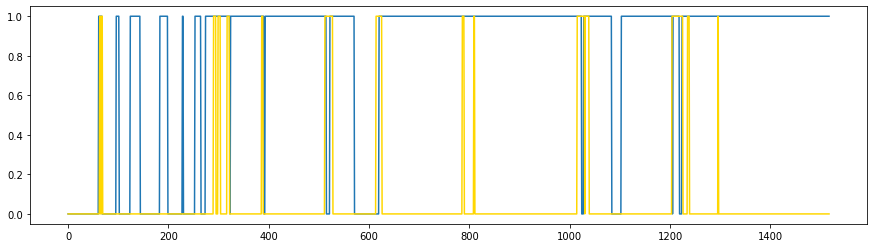

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
plt.plot(result.index, result['ADULT'])
plt.plot(result.index, result['CHILD'], color='gold')
plt.show()

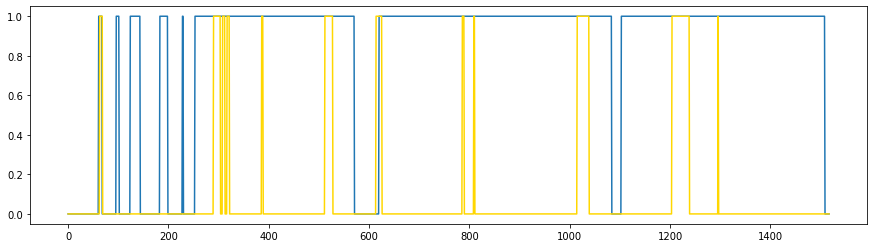

In [31]:
plt.figure(figsize=(15, 4))
plt.plot(result.index, result['SMOOTH_A'])
plt.plot(result.index, result['SMOOTH_C'], color='gold')
plt.show()

In [32]:
result.to_csv('./TestData/eNY-0287.csv')

## TeacherPrint Data

In [33]:
def convert(n): 
    return time.strftime("%M min %S sec", time.gmtime(n))

### Summary

In [34]:
# Calculate the total time (sec).
tp_time = round(len(result.index)*.1,1)
print("TOTAL LESSON TIME: " + convert(tp_time)) 

TOTAL LESSON TIME: 02 min 31 sec


### Talk Time
#### Raw

In [35]:
# Calculate total talktime (sec).
tp_tt = round(((result['ADULT'].sum() + result['CHILD'].sum())*.1), 1)
print("TOTAL TALK TIME: " + convert(tp_tt)) 

# Calculate teacher talktime (sec and %).
tp_ttt = round(result['ADULT'].sum()*.1, 1)
tp_ttt_pc = int(round((tp_ttt/tp_tt)*100, 0))
print(tp_ttt, tp_ttt_pc)

# Calculate student talktime (sec and %).
tp_stt = round(result['CHILD'].sum()*.1, 1)
tp_stt_pc = int(round((tp_stt/tp_tt)*100, 0))
print(tp_stt, tp_stt_pc)

print('During your lesson you spoke ' 
      + str(tp_ttt_pc) + '% of the time and the Students spoke ' 
      + str(tp_stt_pc) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_tt_metric = int(round(tp_ttt/tp_stt, 0))
print('For every second of Student talk time, there were about ' 
      + str(tp_tt_metric) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 02 min 12 sec
121.9 92
10.6 8
During your lesson you spoke 92% of the time and the Students spoke 8% of the time.
For every second of Student talk time, there were about 12 seconds of Teacher talk time.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [36]:
# Calculate total smoothed talktime (sec).
tp_smtt = round(((result['SMOOTH_A'].sum() + result['SMOOTH_C'].sum())*.1), 1)
print("TOTAL TALK TIME: " + convert(tp_smtt)) 

# Calculate teacher talktime (sec and %).
tp_sttt = round(result['SMOOTH_A'].sum()*.1, 1)
tp_sttt_pc = int(round((tp_sttt/tp_smtt)*100, 0))
print(tp_sttt, tp_sttt_pc)

# Calculate student talktime (sec and %).
tp_sstt = round(result['SMOOTH_C'].sum()*.1, 1)
tp_sstt_pc = int(round((tp_sstt/tp_smtt)*100, 0))
print(tp_sstt, tp_sstt_pc)

print('During your lesson you spoke ' 
      + str(tp_sttt_pc) + '% of the time and the Students spoke ' 
      + str(tp_sstt_pc) + '% of the time.')

# Calculate the Talk Time metric ("For every second...".
tp_stt_metric = int(round(tp_sttt/tp_sstt, 0))
print('For every second of Student talk time, there were about ' 
      + str(tp_stt_metric) + ' seconds of Teacher talk time.')

TOTAL TALK TIME: 02 min 16 sec
123.9 91
12.7 9
During your lesson you spoke 91% of the time and the Students spoke 9% of the time.
For every second of Student talk time, there were about 10 seconds of Teacher talk time.


### Statements
#### Raw

In [37]:
#Calculate number of statements.
tp_utt_t = result['UTT_A'].value_counts()[1]
tp_utt_s = result['UTT_C'].value_counts()[1]
tp_utt = tp_utt_t + tp_utt_s
print(tp_utt, tp_utt_t, tp_utt_s)

# Calculate average statement length.
tp_uttlen_t = round((tp_ttt/tp_utt_t), 1)
print(tp_uttlen_t)
tp_uttlen_s = round((tp_stt/tp_utt_s), 1)
print(tp_uttlen_s)

print('Your average statement was ' 
      + str(tp_uttlen_t) + ' seconds long, while the average Student statement was ' 
      + str(tp_uttlen_s) + ' seconds long.')

30 15 15
8.1
0.7
Your average statement was 8.1 seconds long, while the average Student statement was 0.7 seconds long.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [38]:
#Calculate number of smoothed statements.
tp_sutt_t = result['SMOOTH_UTT_A'].value_counts()[1]
tp_sutt_s = result['SMOOTH_UTT_C'].value_counts()[1]
tp_sutt = tp_sutt_t + tp_sutt_s
print(tp_sutt, tp_sutt_t, tp_sutt_s)

# Calculate average smoothed statement length.
tp_suttlen_t = round((tp_ttt/tp_sutt_t), 1)
print(tp_suttlen_t)
tp_suttlen_s = round((tp_stt/tp_sutt_s), 1)
print(tp_suttlen_s)

print('Your average statement was ' 
      + str(tp_suttlen_t) + ' seconds long, while the average Student statement was ' 
      + str(tp_suttlen_s) + ' seconds long.')

20 8 12
15.2
0.9
Your average statement was 15.2 seconds long, while the average Student statement was 0.9 seconds long.


### Turns (Holding the Floor)
#### Raw

In [39]:
# Calculate teacher turns (sec and %).
tp_turn_t = round(result['TURN_A'].sum()*.1, 1)
tp_turn_t_pc = int(round((tp_turn_t/tp_tt)*100, 0))
print(tp_turn_t, tp_turn_t_pc)

# Calculate student turns (sec and %).
tp_turn_s = round(result['TURN_C'].sum()*.1, 1)
tp_turn_s_pc = int(round((tp_turn_s/tp_tt)*100, 0))
print(tp_turn_s, tp_turn_s_pc)

print('You held the floor for ' 
      + str(tp_turn_t_pc) + '% of the total talk time, while the Students held the floor for ' 
      + str(tp_turn_s_pc) + '% of the total talk time. Teacher and Students both spoke for the remainder of the time.')

113.7 86
2.4 2
You held the floor for 86% of the total talk time, while the Students held the floor for 2% of the total talk time. Teacher and Students both spoke for the remainder of the time.


#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [40]:
# Calculate teacher turns (sec and %).
tp_sturn_t = round(result['SMOOTH_TURN_A'].sum()*.1, 1)
tp_sturn_t_pc = int(round((tp_sturn_t/tp_smtt)*100, 0))
print(tp_sturn_t, tp_sturn_t_pc)

# Calculate student turns (sec and %).
tp_sturn_s = round(result['SMOOTH_TURN_C'].sum()*.1, 1)
tp_sturn_s_pc = int(round((tp_sturn_s/tp_smtt)*100, 0))
print(tp_sturn_s, tp_sturn_s_pc)

print('You held the floor for ' 
      + str(tp_sturn_t_pc) + '% of the total talk time, while the Students held the floor for ' 
      + str(tp_sturn_s_pc) + '% of the total talk time. Teacher and Students both spoke for the remainder of the time.')

111.9 82
0.7 1
You held the floor for 82% of the total talk time, while the Students held the floor for 1% of the total talk time. Teacher and Students both spoke for the remainder of the time.


### Overlaps

In [41]:
# Calculate overlap time (sec).
tp_ot = round(result['OVERLAP'].sum()*.1, 1)
print(tp_ot)

# Calculate smoothed overlap time (sec).
tp_sot = round(result['SMOOTH_OVERLAP'].sum()*.1, 1)
print(tp_sot)

8.2
12.0


### Pauses

In [42]:
# Calculate pause time (sec).
tp_pt = round(result['PAUSE'].sum()*.1, 1)
print(tp_pt)

# Calculate smoothed pause time (sec).
tp_spt = round(result['SMOOTH_PAUSE'].sum()*.1, 1)
print(tp_spt)

27.5
27.2


### Speaker Wheel
#### Raw

In [43]:
# Calculate Speaker Wheel input values (percent).
sw_adult = int(round((tp_ttt-tp_ot)/tp_time*100))
sw_overlap = int(round(tp_ot/tp_time*100))
sw_child = int(round((tp_stt-tp_ot)/tp_time*100))
sw_pause = int(round(tp_pt/tp_time*100))
sw_df = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
sw_df

{'TEACHER': 75, 'OVERLAPS': 5, 'STUDENT': 2, 'PAUSES': 18}

#### Smoothed
Pauses of one second or less between consecutive statements are smoothed out.

In [44]:
# Calculate Speaker Wheel input values (percent) based on smoothed data.
ssw_adult = int(round((tp_sttt-tp_sot)/tp_time*100))
ssw_overlap = int(round(tp_sot/tp_time*100))
ssw_child = int(round((tp_sstt-tp_sot)/tp_time*100))
ssw_pause = int(round(tp_spt/tp_time*100))
ssw_df = {"TEACHER": sw_adult, "OVERLAPS": sw_overlap, "STUDENT": sw_child, "PAUSES": sw_pause}
ssw_df

{'TEACHER': 75, 'OVERLAPS': 5, 'STUDENT': 2, 'PAUSES': 18}